In [1]:
# Useful for debugging
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
from matplotlib import pyplot as plt

In [2]:
from gpt.element import Lattice
from gpt.maps import Map25D_TM
from gpt import GPT
from pmd_beamphysics import single_particle

from distgen.physical_constants import qe, c, MC2
import os

MC2=MC2.magnitude
c = c.magnitude

def p2e(p):
    return np.sqrt(p**2 + MC2**2)

def p2g(p):
    return np.sqrt((p/MC2)**2 - 1)

def p2b(p):
    return np.sqrt(1-1/p2g(p)**2)


In [3]:
lat = Lattice('Linac-Example')

cnames={'z':'z', 'r':'r', 'Ez':'Ez', 'Er':'Er', 'Bphi':'Bphi'}

lat.add(Map25D_TM('cav01', 'fields/7cell_2D.gdf', column_names=cnames, frequency=1.3e9, scale=6e6), ds=0)
lat.add(Map25D_TM('cav02', 'fields/7cell_2D.gdf', column_names=cnames, frequency=1.3e9, scale=6e6), ds=0.25)
lat.add(Map25D_TM('cav03', 'fields/7cell_2D.gdf', column_names=cnames, frequency=1.3e9, scale=6e6), ds=0.25)
lat.add(Map25D_TM('cav04', 'fields/7cell_2D.gdf', column_names=cnames, frequency=1.3e9, scale=6e6, relative_phase=-180), ds=0.25)
lat.add(Map25D_TM('cav05', 'fields/7cell_2D.gdf', column_names=cnames, frequency=1.3e9, scale=6e6, relative_phase=-180), ds=0.25)
lat.add(Map25D_TM('cav06', 'fields/7cell_2D.gdf', column_names=cnames, frequency=1.3e9, scale=6e6, relative_phase=-180), ds=0.25)

Field map does not contain item "R"
Field map does not contain item "R"
Field map does not contain item "R"
Field map does not contain item "R"
Field map does not contain item "R"
Field map does not contain item "R"
Field map does not contain item "R"
Field map does not contain item "R"
Field map does not contain item "R"
Field map does not contain item "R"
Field map does not contain item "R"
Field map does not contain item "R"


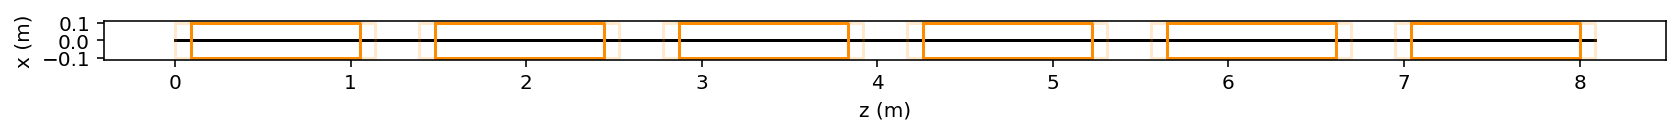

In [4]:
plt.figure(figsize=(14,5))
lat.plot_floor();

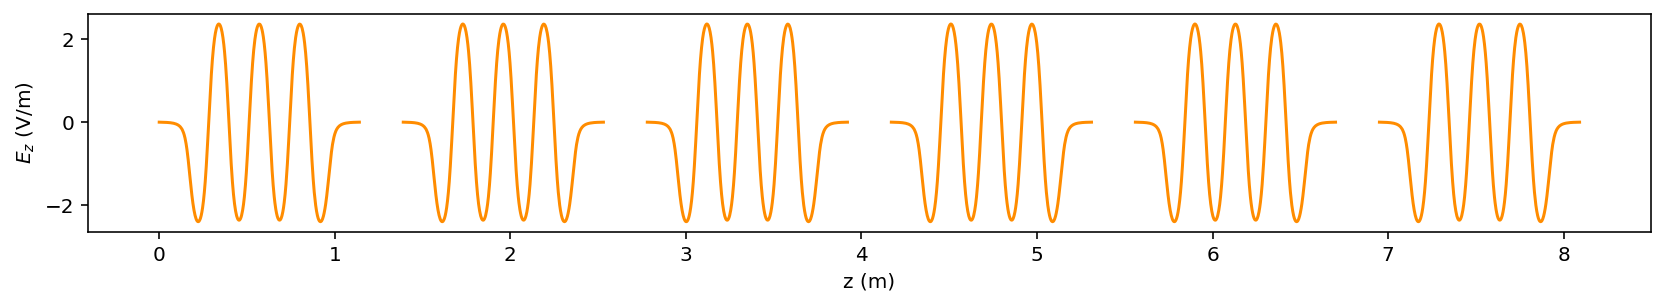

In [5]:
plt.figure(figsize=(14,2))
lat.plot_field_profile();

In [6]:
import time

t = 0
p = 5.8e6

t_start = [t]
p_start = [p]
z_start = [lat[0].s_beg]

runs = []

for ii, current_element in enumerate(lat._elements):
    
    current_t_start = t_start[-1]
    current_p_start = p_start[-1]
    
    if(current_element.type in ['Map1D_TM', 'Map25D_TM']):
        
        print(f'\n> Phasing: {current_element.name}')
        print(f'   t_beg = {current_t_start} sec.')
        print(f'   s_beg = {current_element.s_beg} m.')
        print(f'   scale = {current_element._scale}.')
        print(f'   relative phase = {current_element._relative_phase} deg.')
        
        # phase
        t1 = time.time()
        run = current_element.autophase(t=current_t_start, p=current_p_start)
        t2 = time.time()
        current_t_stop = run.screen[-1]['mean_t']
        current_p_stop = run.screen[-1]['mean_p']
        b_stop = run.screen[-1]['mean_beta']
        
        print(f'\n   t_end = {current_t_stop} m.')
        print(f'   s_end = {current_element.s_end} m.')
        print(f'   oncrest phase = {current_element._oncrest_phase}')
        print(f'   energy gain =  {p2e(current_p_stop)-p2e(current_p_start):0.3f} eV.')
        print(f'\nEllapsed time =  {t2-t1:0.3f} sec.')
        
        if(ii<len(lat._elements)-1):
            
            next_element = lat._elements[ii+1]
            ds_to_next = next_element.s_beg - current_element.s_end
            dt_to_next = ds_to_next/c/b_stop
            
        else:
            
            dt_to_next = 0
            
        t_start.append(current_t_stop + dt_to_next)
        p_start.append(current_p_stop)
        z_start.append(current_element.s_end+ds_to_next)
        
        runs.append(run)
        


> Phasing: cav01
   t_beg = 0 sec.
   s_beg = 0 m.
   scale = 6000000.0.
   relative phase = 0 deg.

   t_end = 3.810467333531857e-09 m.
   s_end = 1.14 m.
   oncrest phase = 7.605687807186996
   energy gain =  5985287.370 eV.

Ellapsed time =  4.781 sec.

> Phasing: cav02
   t_beg = 4.645159568860554e-09 sec.
   s_beg = 1.39 m.
   scale = 6000000.0.
   relative phase = 0 deg.

   t_end = 8.450216667277459e-09 m.
   s_end = 2.53 m.
   oncrest phase = -4.523117264883922
   energy gain =  5994975.720 eV.

Ellapsed time =  5.525 sec.

> Phasing: cav03
   t_beg = 9.284470640923295e-09 sec.
   s_beg = 2.78 m.
   scale = 6000000.0.
   relative phase = 0 deg.

   t_end = 1.3088288903218868e-08 m.
   s_end = 3.92 m.
   oncrest phase = -15.350048259517052
   energy gain =  5997284.297 eV.

Ellapsed time =  4.865 sec.

> Phasing: cav04
   t_beg = 1.3922391417213279e-08 sec.
   s_beg = 4.17 m.
   scale = 6000000.0.
   relative phase = -180 deg.

   t_end = 1.7726209706577494e-08 m.
   s_end = 5.

In [7]:
lat.write_gpt_lines(output_file='gpt.temp.in');

G = GPT('gpt.temp.in', initial_particles = single_particle(z=z_start[0], pz=p, t=t))

settings = {'tmax':1.1*lat[-1]._t_end, 'ZSTOP':1.1*lat[-1]._s_end, 'Ntout':500}
G.set_variables(settings)
G.run()


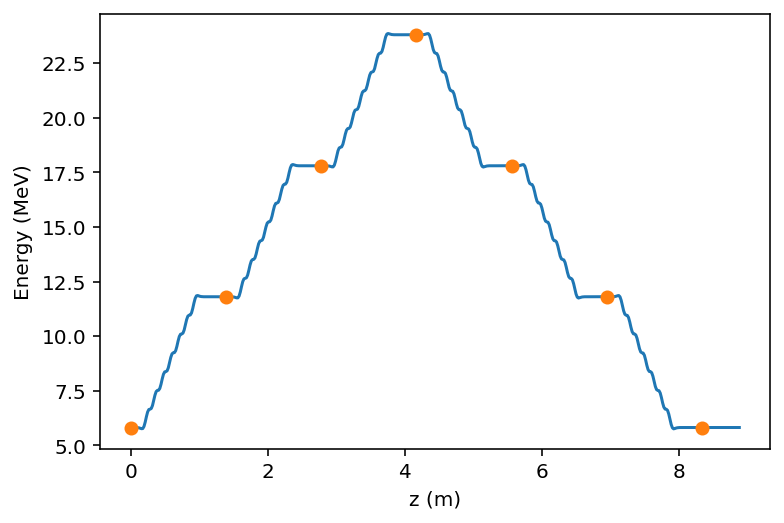

In [8]:
plt.plot(G.stat('mean_z'), G.stat('mean_energy')/1e6)
plt.plot(z_start, np.array(list(map(p2e, p_start)))/1e6, 'o');
plt.xlabel('z (m)');
plt.ylabel('Energy (MeV)');

In [9]:
lat = Lattice('Linac-Example')

cnames={'z':'z', 'r':'r', 'Ez':'Ez', 'Er':'Er', 'Bphi':'Bphi'}

lat.add(Map25D_TM('cav01', 'fields/7cell_2D.gdf', column_names=cnames, frequency=1.3e9, scale=6e6), ds=0)
lat.add(Map25D_TM('cav02', 'fields/7cell_2D.gdf', column_names=cnames, frequency=1.3e9, scale=6e6), ds=0.25)
lat.add(Map25D_TM('cav03', 'fields/7cell_2D.gdf', column_names=cnames, frequency=1.3e9, scale=6e6), ds=0.25)
lat.add(Map25D_TM('cav04', 'fields/7cell_2D.gdf', column_names=cnames, frequency=1.3e9, scale=6e6, relative_phase=-180), ds=0.25)
lat.add(Map25D_TM('cav05', 'fields/7cell_2D.gdf', column_names=cnames, frequency=1.3e9, scale=6e6, relative_phase=-180), ds=0.25)
lat.add(Map25D_TM('cav06', 'fields/7cell_2D.gdf', column_names=cnames, frequency=1.3e9, scale=6e6, relative_phase=-180), ds=0.25)

from  gpt.template import ztrack1_template
t = 0
p = 5.8e6

ts=[]
ps=[]
zs=[]

runs = []

rf_elements = [element for element in lat._elements if(element.type in ['Map1D_TM', 'Map25D_TM'])]

# Check that rf_elements do not overlap:
for ii, cav in enumerate(rf_elements[:-1]):
    if(ii+1<len(rf_elements)):
        next_cav = rf_elements[ii+1]
        assert cav.z_end_ccs <= next_cav.z_beg_ccs, f'Autophasing Error: cavities {cav.name} and {next_cav.name} overlap and cannot be phased.'

# Track up to 1st cavity
# skip for now

current_t = t
current_p = p
current_z = lat[0].s_beg

# Autophase first cavity
for ii, rf_element in enumerate(rf_elements):
    
    assert np.abs(current_z - rf_element.z_beg_ccs)<1e-14, f'Error Phasing {rf_element.name}: particle was not located at cavity entrance.'

    print(f'\n> Phasing: {rf_element.name}')
    print(f'   t_beg = {current_t} sec.')
    print(f'   s_beg = {rf_element.s_beg} m.')
    print(f'   scale = {rf_element._scale}.')
    print(f'   relative phase = {rf_element._relative_phase} deg.')
    
    ts.append(current_t)
    ps.append(current_p)
    zs.append(current_z)
    
    # phase
    t1 = time.time()
    run = rf_element.autophase(t=current_t, p=current_p)
    t2 = time.time()
    
    current_t = run.screen[-1]['mean_t']
    current_p = run.screen[-1]['mean_p']
    current_z = run.screen[-1]['mean_z']
        
    print(f'\n   t_end = {current_t} m.')
    print(f'   s_end = {rf_element.s_end} m.')
    print(f'   oncrest phase = {rf_element._oncrest_phase}')
    print(f'   energy gain =  {p2e(current_p)-p2e(ps[-1]):0.3f} eV.')
    print(f'\n   Ellapsed time =  {t2-t1:0.3f} sec.')
    
    ts.append(current_t)
    ps.append(current_p)
    zs.append(current_z)
    
    if(ii+1 < len(rf_elements)):  # Track to next cavity
        
        next_rf_element=rf_elements[ii+1]
        next_rf_element_index = lat.element_index(next_rf_element.name)
        
        lat_temp = Lattice('temp')
        lat_temp._elements = lat._elements[:next_rf_element_index]
        lat_temp.write_gpt_lines(ztrack1_template(), output_file='gpt.temp.in')
        
        print(f'\n> Tracking: {rf_element.name}:{next_rf_element.name}')
        #print(f'   t_beg = {current_t} sec.')
        #print(f'   s_beg = {rf_element.s_end} m.')
        
        G = GPT('gpt.temp.in')
        fparticle = G.track1_in_ccs(current_z, rf_elements[ii+1].z_beg_ccs, pz0=current_p, t0=current_t)
        
        assert fparticle is not None, f'Particle tracking from {rf_element.name} to {rf_elements[ii+1].name} failed.'
        assert np.abs( fparticle.screen[-1]['mean_z']-rf_elements[ii+1].z_beg_ccs ) < 1e-14, f'Error Phasing {rf_element.name}: particle was not located at cavity entrance after tracking to cavity.'

        current_t = fparticle.screen[-1]['mean_t']
        current_p = fparticle.screen[-1]['mean_p']
        current_z = fparticle.screen[-1]['mean_z']
        
        #print(f'\n   t_end = {current_t} sec.')
        #print(f'   s_end = {next_rf_element.s_beg} m.')
        print(f'   energy gain: { (p2e(current_p)-p2e(ps[-1]))/p2e(ps[-1])} eV.')
        
    else:  # Track to end
        pass
        


> Phasing: cav01
   t_beg = 0 sec.
   s_beg = 0 m.
   scale = 6000000.0.
   relative phase = 0 deg.

   t_end = 3.810467333531857e-09 m.
   s_end = 1.14 m.
   oncrest phase = 7.605687807186996
   energy gain =  5985287.370 eV.

   Ellapsed time =  5.158 sec.

> Tracking: cav01:cav02
   energy gain: -4.259185802893681e-15 eV.

> Phasing: cav02
   t_beg = 4.645159568860699e-09 sec.
   s_beg = 1.39 m.
   scale = 6000000.0.
   relative phase = 0 deg.

   t_end = 8.450216665429913e-09 m.
   s_end = 2.53 m.
   oncrest phase = -4.521784295162888
   energy gain =  5994975.722 eV.

   Ellapsed time =  5.732 sec.

> Tracking: cav02:cav03
   energy gain: 9.772156166957903e-14 eV.

> Phasing: cav03
   t_beg = 9.28447063907578e-09 sec.
   s_beg = 2.78 m.
   scale = 6000000.0.
   relative phase = 0 deg.

   t_end = 1.3088288901355434e-08 m.
   s_end = 3.92 m.
   oncrest phase = -15.350013148653716
   energy gain =  5997284.299 eV.

   Ellapsed time =  5.643 sec.

> Tracking: cav03:cav04
   energy g

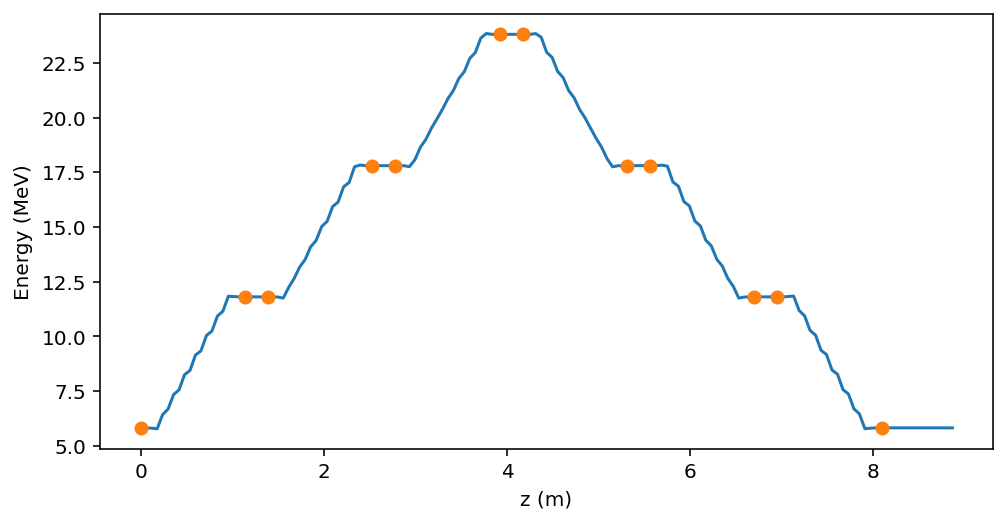

In [10]:
lat.write_gpt_lines(output_file='gpt.temp.in');

G = GPT('gpt.temp.in', initial_particles = single_particle(z=z_start[0], pz=p, t=t))
settings = {'tmax':1e-7, 'ZSTOP':1.1*lat[-1]._s_end, 'Ntout':500}
G.set_variables(settings)
G.run()

plt.figure(figsize=(8,4))
plt.plot(G.stat('mean_z'), G.stat('mean_energy')/1e6)
plt.plot(zs, np.array(list(map(p2e, ps)))/1e6, 'o');
plt.xlabel('z (m)');
plt.ylabel('Energy (MeV)');

In [11]:
os.remove('gpt.temp.in')

In [12]:
from gpt.autoscale import autophase1

In [13]:
autophase1(lat, t=0, p=5.8e6)


> Phasing: cav01
   t_beg = 0 sec.
   s_beg = 0 m.
   scale = 6000000.0.
   relative phase = 0 deg.

   t_end = 3.810467333531857e-09 m.
   s_end = 1.14 m.
   oncrest phase = 7.605687807186996
   energy gain =  5985287.370 eV.

   Ellapsed time =  6.408 sec.

> Tracking: cav01:cav02
   energy gain: -4.259185802893681e-15 eV.

> Phasing: cav02
   t_beg = 4.645159568860699e-09 sec.
   s_beg = 1.39 m.
   scale = 6000000.0.
   relative phase = 0 deg.

   t_end = 8.450216665429913e-09 m.
   s_end = 2.53 m.
   oncrest phase = -4.521784295162888
   energy gain =  5994975.722 eV.

   Ellapsed time =  7.558 sec.

> Tracking: cav02:cav03
   energy gain: 9.772156166957903e-14 eV.

> Phasing: cav03
   t_beg = 9.28447063907578e-09 sec.
   s_beg = 2.78 m.
   scale = 6000000.0.
   relative phase = 0 deg.

   t_end = 1.3088288901355434e-08 m.
   s_end = 3.92 m.
   oncrest phase = -15.350013148653716
   energy gain =  5997284.299 eV.

   Ellapsed time =  9.142 sec.

> Tracking: cav03:cav04
   energy g

([0,
  0,
  3.810467333531857e-09,
  4.645159568860699e-09,
  8.450216665429913e-09,
  9.28447063907578e-09,
  1.3088288901355434e-08,
  1.3922391415354363e-08,
  1.7726209704427013e-08,
  1.8560463677786474e-08,
  2.2365520954294055e-08,
  2.3200213184762186e-08,
  2.701068408970187e-08],
 [5800000.0,
  5800000.0,
  11796691.874870125,
  11796691.874870075,
  17795394.70026509,
  17795394.70026683,
  23794527.87286463,
  23794527.87286237,
  17795402.190582395,
  17795402.19058142,
  11796728.523310926,
  11796728.52331108,
  5800325.814773391],
 [0,
  0,
  1.14,
  1.39,
  2.53,
  2.78,
  3.92,
  4.170000000000001,
  5.31,
  5.56,
  6.699999999999999,
  6.949999999999999,
  8.09],
 <gpt.gpt.GPT at 0x7fbbc81b1850>)